Подключу используемые библиотеки и файлы

In [1]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/Yuichir0/Telecom/thinkdsp.py

from thinkdsp import decorate, read_wave, unbias, normalize, Spectrum, Wave, Noise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Упражнение 4.1

На сайте Soft Murmur можно послушать множество природных источников шума, включая дождь, волны, ветер и др. На веб-странице http://asoftmurmur.com/about/ приведен перечень записей; большинство из них хранится на http://freesound.org.

Скачайте некоторые из этих файлов и вычислите спектры каждого сигнала. Похож ли их спектр мощности на белый, розовый или броуновский шум? Как спектр меняется во времени?

### Решение

Загружу звуки ветра и дождя

In [2]:
if not os.path.exists('wind.wav'):
    !wget https://github.com/Yuichir0/Telecom/wind.wav
if not os.path.exists('575463__trashcanstudios__003-rain-from-in-garage.wav'):
    !wget https://github.com/Yuichir0/Telecom/575463__trashcanstudios__003-rain-from-in-garage.wav

In [3]:
wind = read_wave('wind.wav').segment(start=1, duration=3.0)
wind.make_audio()

And here's its spectrum:

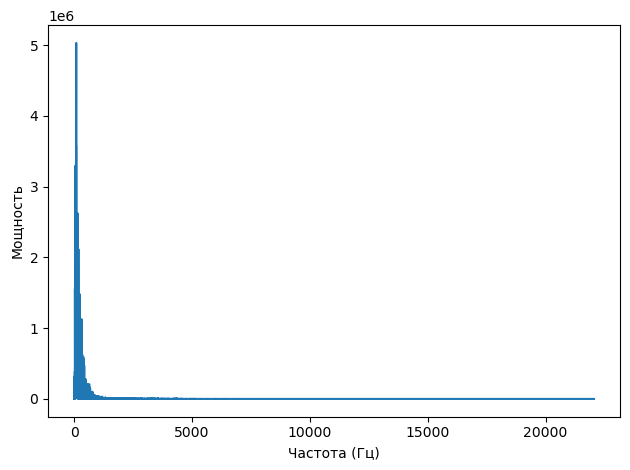

In [4]:
wind_spectrum = wind.make_spectrum()
wind_spectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность')

По графику видно, что амплитуда падает с возрастанием частоты, значит это красный или розовый шум. 
Чтобы узнать точнее, распечатаю спектр мощности в логарифмической шкале

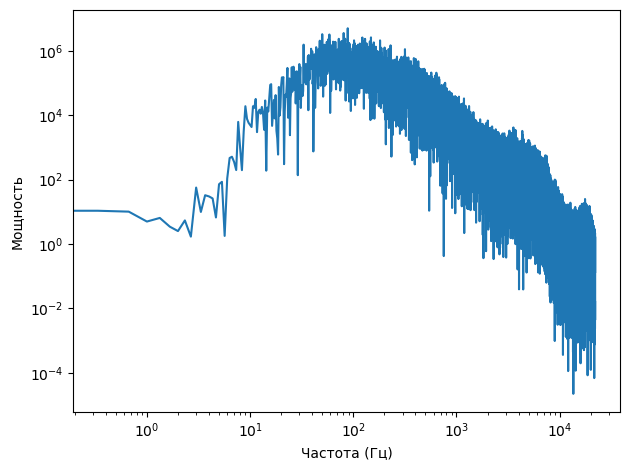

In [5]:
wind_spectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

По структуре график весьма похож на красный шум, сначала возрастая, а затем около 10^2 Гц примерно линейно падая.
Проверю этот шум еще раз на другом сегменте

In [6]:
wind2 = read_wave('wind.wav').segment(start=4.0, duration=3.0)
wind2.make_audio()

-2.8818001651414495

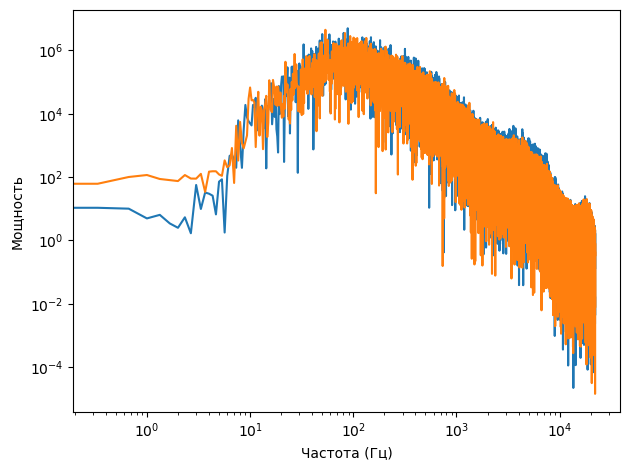

In [7]:
wind_spectrum2 = wind2.make_spectrum()
wind_spectrum.plot_power()
wind_spectrum2.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))
wind_spectrum.estimate_slope()[0]

График не претерпевает сильных изменений по времени.
Теперь повторю построение на примере звуков дождя

In [8]:
rain = read_wave('575463__trashcanstudios__003-rain-from-in-garage.wav').segment(start=1, duration=3.0)
rain2 = read_wave('575463__trashcanstudios__003-rain-from-in-garage.wav').segment(start=4, duration=3.0)
rain.make_audio()

In [9]:
rain2.make_audio()

-1.3837795931743309

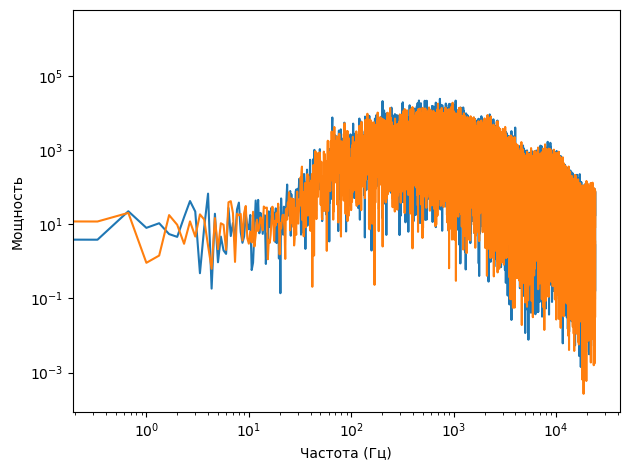

In [10]:
rain_spectrum = rain.make_spectrum()
rain_spectrum2 = rain2.make_spectrum()
rain_spectrum.plot_power()
rain_spectrum2.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))
rain_spectrum.estimate_slope()[0]

У получившегося графика более постоянная мощность, чем у звука ветра, и он получился ближе к розовому шуму

### Упражнение 4.2
В шумовом сигнале частотный состав меняется во времени. На большом интервале мощность на всех частотах одинакова, а на коротком мощность на каждой частоте случайна.

Для оценки долговременной средней мощности на каждой частоте можно разорвать сигнал на сегменты, вычислить спектр мощности для каждого сегмента, а затем найти среднее по сегментам.

Реализуйте метод Бартлетта и используйте его для оценки спектра мощности шумового сигнала. Подсказка: посмотрите на реализацию make_spectrogram.

### Решение
Реализую метод Барлетта

In [11]:
def bartlett_method(wave, seg_length=512, win_flag=True):
  spectrum = wave.make_spectrogram(seg_length, win_flag)
  segments = spectrum.spec_map.values()
  power_segments = []
  for segment in segments:
    power_segments.append(segment.power)
  hs = np.sqrt(sum(power_segments)/len(power_segments))
  fs = next(iter(segments)).fs
  spectrum = Spectrum(hs, fs, wave.framerate)
  return spectrum

Исследуем работу алгоритма на используемых выше сегментах.

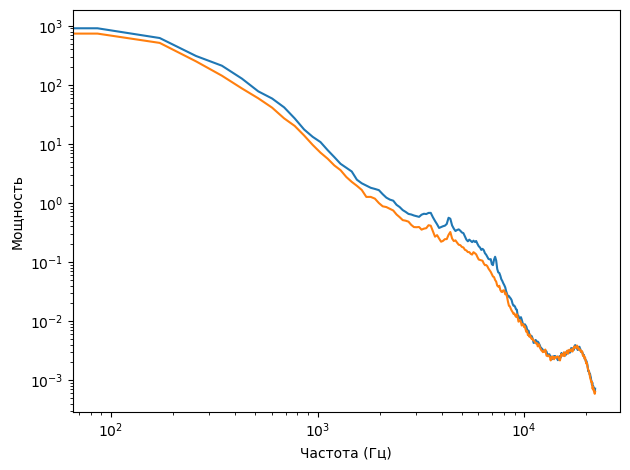

In [12]:
windBT = bartlett_method(wind)
windBT2 = bartlett_method(wind2)

rainBT = bartlett_method(rain)
rainBT2 = bartlett_method(rain2)

windBT.plot_power()
windBT2.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

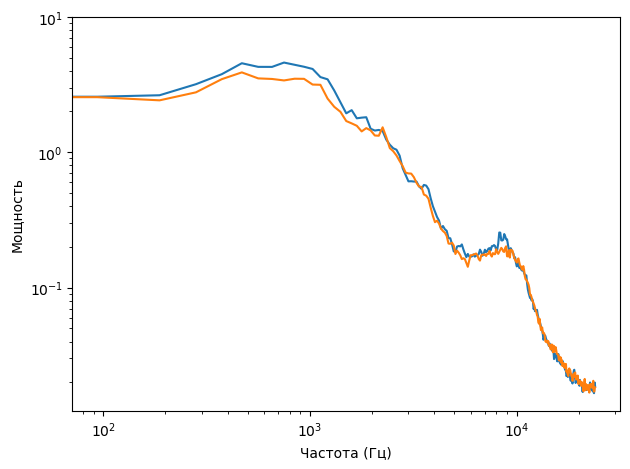

In [13]:
rainBT.plot_power()
rainBT2.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

Судя по всему, тип шума у звука ветра был определен более или менее корректно - он также напоминает красный шум. 
У звука же дождя определить тип шума сложнее - его сложно классифицировать

### Упражнение 4.3
На веб-странице http://www.coindesk.com/price можно скачать в ввиде CSV-файла исторические данные о ежедневной цене BitCoin. Откройте этот файл и вычислите спектр цен BitCoin как функцию времени. Похоже ли это на белый, розовый или броуновский шум?

### Решение
Загружу данные о цене биткоина за 2013-2020 года

In [14]:
if not os.path.exists('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv'):
    !wget https://github.com/Yuichir0/Telecom/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv
df = pd.read_csv('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv',
                 parse_dates=[0])
df

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.654990,124.304660,124.751660,122.563490
1,BTC,2013-10-02,125.455000,123.654990,125.758500,123.633830
2,BTC,2013-10-03,108.584830,125.455000,125.665660,83.328330
3,BTC,2013-10-04,118.674660,108.584830,118.675000,107.058160
4,BTC,2013-10-05,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...,...
2354,BTC,2020-03-22,5884.340133,6187.042146,6431.873162,5802.553402
2355,BTC,2020-03-23,6455.454688,5829.352511,6620.858253,5694.198299
2356,BTC,2020-03-24,6784.318011,6455.450650,6863.602196,6406.037439
2357,BTC,2020-03-25,6706.985089,6784.325204,6981.720386,6488.111885


In [15]:
ys = df['Closing Price (USD)']
ts = df.index

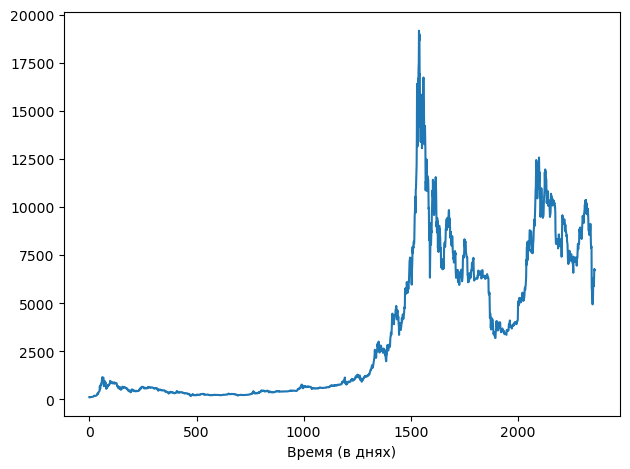

In [16]:
wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Время (в днях)')

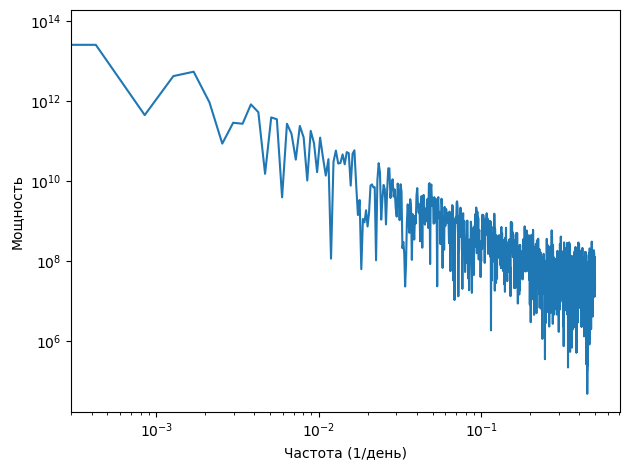

In [18]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Частота (1/день)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [19]:
spectrum.estimate_slope()[0]

-1.7332540936758956

У красного шума наклон должен быть около -2, так что этот график скорее относится к розовому шуму

### Упражнение 4.4
Счетчик Гейгера - прибор для обнаружения радиации. Когда ионизирующи частицы попадают в детектор, на его выходе появляются импульсы тока. Общий выход в определенный момент времени можно смоделировать некоррелированным пуассоновым шумом (UP), где каждая выборка есть случайное число из распределения Пуассона, соответствующее количеству частиц, обнаруженных за интервал измерения.

Напишите класс, называемый UncorrelatedPoissonNoise, наследующий thinkdsp._Noise и предоставляющий evaluate. Следует использовать Np.random.poisson для генерации случайный величин из распределения Пуассона. Параметр этой функции lam - это среднее число частиц за время каждого интервала. Можно использовать атрибут amp для определения lam. Например, при чатоте кадров 10 кГц и amp 0,001 получится около 10 "щелчков" в секунду.

Сгенерируйте пару секунд UP и прослушайте. Для малых значений amp, например 0,001, звук будет как у счетчика Гейгера. При больших значениях он будет похож на белый шум. Вычислите и напечатайте спектр мощности и посмотрите, так ли это.

### Решение

Напишу класс по заданию

In [20]:
class UncorrelatedPoissonNoise(Noise):
    def evaluate(self, ts):
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Шум при низкой радиации

In [22]:
amp = 0.001
framerate = 10000
duration = 1

signalLow = UncorrelatedPoissonNoise(amp=amp)
geigerLow = signalLow.make_wave(duration=duration, framerate=framerate)
geigerLow.make_audio()

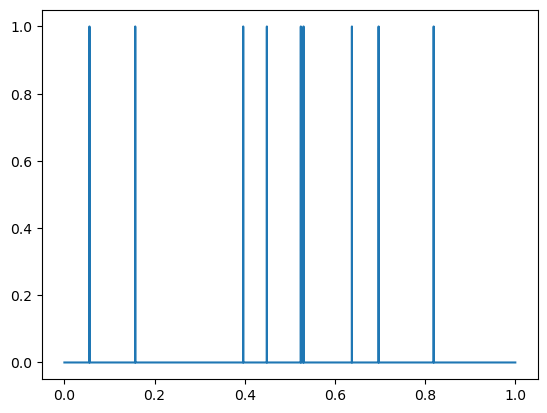

In [23]:
geigerLow.plot()

Построю звук на спектрограмме

0.011494646334456198

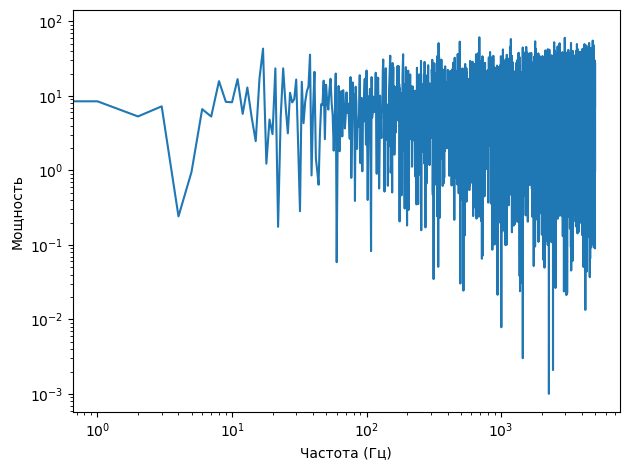

In [25]:
geigerLowSpectrum = geigerLow.make_spectrum()
geigerLowSpectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))
geigerLowSpectrum.estimate_slope().slope

Выглядит как спектрограмма белого шума.
Увеличу значение амплитуды

In [26]:
amp = 1

signalHigh = UncorrelatedPoissonNoise(amp=amp)
geigerHigh = signalHigh.make_wave(duration=duration, framerate=framerate)
geigerHigh.make_audio()

waveform-а теперь более похожа на таковую у сигналов

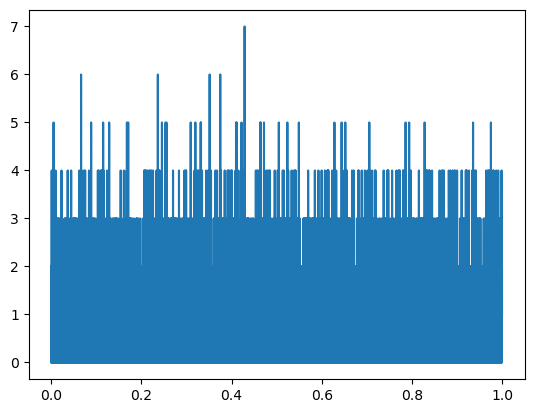

In [27]:
geigerHigh.plot()

-0.04534407552860597

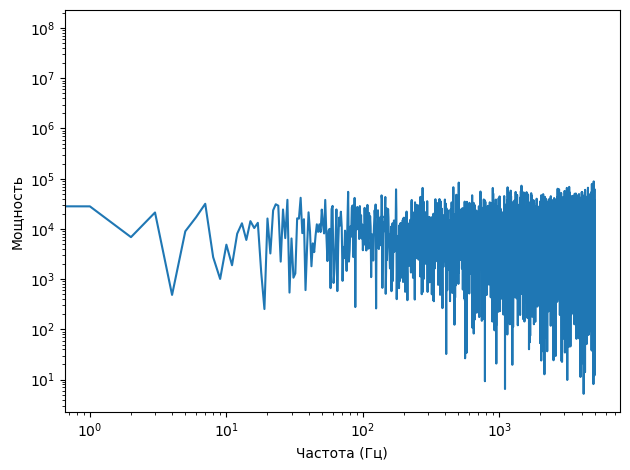

In [29]:
geigerHighSpectrum = geigerHigh.make_spectrum()
geigerHighSpectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))
geigerHighSpectrum.estimate_slope().slope

Как можно заметить, при высокой амплитуде это также белый шум

### Упражнение 4.5
В этой главе алгоритм для генерации розового шума концептуально простой, но затратный.
 Существет более эффективные варианты, например алгоритм Voss-McCartney.
 Изучите этот способ, реализуйте его, вычислите спектр результата и убедитесь, что соотношения между мощностью и частотой соответсвующие.

### Решение
Реализую алгоритм Voss-McCartney-я

In [39]:
def voss(rows, columns=16):
      array = np.empty((rows, columns))
      array.fill(np.nan)
      array[0, :] = np.random.random(columns)
      array[:, 0] = np.random.random(rows)

      cols = np.random.geometric(0.5, rows)
      cols[cols >= columns] = 0
      new_rows = np.random.randint(rows, size=rows)
      array[new_rows, cols] = np.random.random(rows)

      data = pd.DataFrame(array)
      data.fillna(method='ffill', axis=0, inplace=True)
      total = data.sum(axis=1)

      return total.values

Проверим его работу при 10000 значениях

C:\Users\Yuichiro\AppData\Local\Temp\ipykernel_9692\2707470351.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', axis=0, inplace=True)


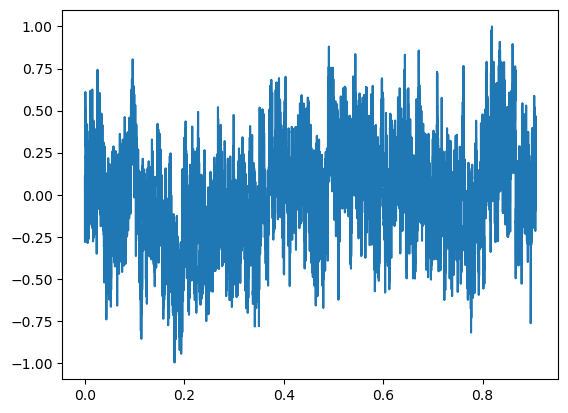

In [40]:
ys = voss(10000)
wave = Wave(ys)
wave.unbias()
wave.normalize()
wave.plot()

Как ожидалось он выглядит более "закономерно", чем белый шум, но более случайным, чем красный

In [41]:
wave.make_audio()

Построю спектрограмму

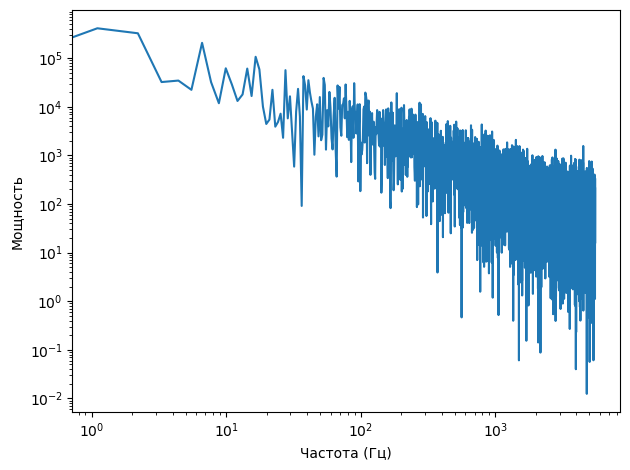

In [42]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Частота (Гц)', ylabel='Мощность', **dict(xscale='log', yscale='log'))

In [43]:
spectrum.estimate_slope().slope

-1.0037916296336487

Наклон ~ -1, что действительно соответствует розовому шуму